In [1]:
import os

import numpy as np
import torch

from matplotlib import pyplot as plt
from scipy.special import softmax, expit
from bin import plotter

In [2]:
out_path = "../figures/pred_coding"
PUB = True
if PUB:
    w = 1.5
    h = 1
else:
    w = 3
    h = 2
os.getcwd()

'/home/bizon/Projects/ColorShapeConcepts/examples'

The model is extremely simple, and is defined as three orthogonal feature dimmensions, each with three discrete values, and 4 "concepts"

In [3]:
input_size = (2, 3)
conceptual_layer = np.zeros(3)

If connectivity is fully diagnostic, then each individual color is fully diagnostic of each shape. THe connectivity matrices for each concept are showm with the third and fourth being "distractor" concepts unrelated to the task. _feature dimensions are rows, values are cols_


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


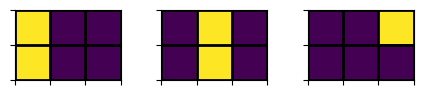

In [4]:
# define concept pieces with numpy slices
# DIAGNOSTIC Connectivity
concepts = (np.s_[:2, 0], np.s_[:2, 1], np.s_[0, 2])
reward = np.array([1, 1, 1, 1])
connectivity = np.zeros((input_size) + (3,))
fig, axs = plt.subplots(1, 3)
fig.tight_layout()
fig.set_size_inches((3 * w, h))
for j, c in enumerate(concepts):
    connectivity[c + (j,)] = 1
    axs[j].imshow(connectivity[..., j])
    axs[j].grid(True,  color='black', linewidth=2.0, which="major")
    axs[j].set_xticks(np.arange(-.5, 3, 1), minor=False)
    axs[j].set_yticks(np.arange(-.5, 2, 1), minor=False)
    axs[j].set_xticklabels([])
    axs[j].set_yticklabels([])
connectivity = connectivity # / np.sum(connectivity, axis=(0, 1), keepdims=True)
fig.savefig(os.path.join(out_path, "concept_true.svg"))
plt.show()

In [5]:
class ConceptFeatureModel:

    def __init__(self, features=3, feature_dims=2, concept_dims=3, connectivity=connectivity,):
        self.percept_size = (features, feature_dims)
        self.concept_evd = np.zeros(concept_dims)
        self.percept_evd = np.zeros(self.percept_size)
        self.connectivity = connectivity
        self.n_concepts = concept_dims
        self.system_noise_sigma_ = .0
        self.measurement_noise_sigma_ = .0

    def predict(self, concept_probs: np.ndarray):
        # exp = connectivity.sum(axis=1).T # 3, 4
        feat_mod = self.connectivity.reshape((-1, self.n_concepts)).T
        predicted = concept_probs @ feat_mod # n feat dims
        return predicted

    def forward(self, percept):
        measure_noise = np.random.normal(size=self.percept_size, scale=self.measurement_noise_sigma_)
        percept = (percept + measure_noise)
        self.percept_evd = .9 * self.percept_evd + .1 * percept
        # prediction from top down
        pred = self.predict(self.concept_evd)
        # compute residual
        res = self.percept_evd.reshape((1, -1)) - pred
        # send residual
        self.concept_evd += .1 * (res @ self.connectivity.reshape((-1, self.n_concepts))).squeeze()
        return res, self.concept_evd

    def __call__(self, *args, **kwargs) -> tuple[np.ndarray[float]]:
        return self.forward(*args, **kwargs)

If we present the full complement of stimuli that defines a specific concept, the model quickly converges to the correct concept (top) and the gain remains low (bottom)

In [6]:
def run_simple_predictive(P, iter=75):
    res_act = []
    top_act = []
    cfm = ConceptFeatureModel(2, 3, 3, connectivity)
    top_act.append(0)
    for i in range(50):
        res, c_evd = cfm(p)
        res_act.append(res)
        top_act.append(np.abs(c_evd).sum())
    #ax[0].set_ylim(0, 1.0)
    res_act = np.concatenate(res_act)
    res_pat = np.mean(res_act, axis=0)
    total_act = np.sum(np.abs(res_act), axis=1)
    return res_pat, total_act

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

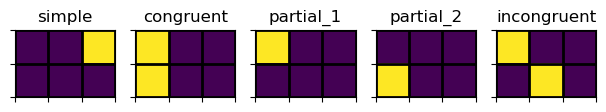

In [7]:
# store all percepts
percepts = {}

# simple stimulus (like achromatic unassociated familiar shape)
p = np.array([[0.0, 0.0, 1.0],
              [0.0, 0.0, 0.0]])
percepts["simple"] = p

# congruent stimulus (like color associated shape)
p = np.array([[1.0, 0.0, 0.0],
              [1.0, 0.0, 0.0]])
percepts["congruent"] = p

# partial congruent stimulus (like grayscale color associated shape)
p = np.array([[1.0, 0.0, 0.0],
              [0.0, 0.0, 0.0]])
percepts["partial_1"] = p

# partial congruent stimulus (like grayscale color associated shape)
p = np.array([[0.0, 0.0, 0.0],
              [1.0, 0.0, 0.0]])
percepts["partial_2"] = p

# incongruent stimulus (like mis-colored color associated shape)
p = np.array([[1.0, 0.0, 0.0],
              [0.0, 1.0, 0.0]])
percepts["incongruent"] = p

# show stimuli
fig, ax = plt.subplots(1, len(percepts))
fig.set_size_inches((5 * w, h))
for i, k in enumerate(percepts.keys()):
    ax[i].imshow(percepts[k], vmin=0, vmax=1)
    ax[i].set_title(k)
    ax[i].grid(True,  color='black', linewidth=2.0, which="major")
    ax[i].set_xticks(np.arange(-.5, 3, 1), minor=False)
    ax[i].set_yticks(np.arange(-.5, 2, 1), minor=False)
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])

fig.savefig(os.path.join(out_path, "tested_stimuli.svg"))

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

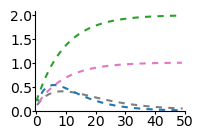

In [8]:
# don't need both partial because both features are symmetric. 
to_plot = ["simple", "congruent", "partial_1", "incongruent"]
data = []
# run models 
for d in to_plot:
    p = percepts[d]
    pat, mag = run_simple_predictive(p)
    data.append(mag)
# create joint activation data for plotting 
data = np.stack(data)[..., None]
mag_fig, mag_ax = plt.subplots()
mag_fig.set_size_inches((w, h))
mag_fig = plotter.create_save_line_plot(mag_ax, mag_fig, "congruent_con_probs", data, out_dir=out_path, set_size=(w, h))
plt.show()

The above shows expected magnitude of activation over time in the lower "perceptual" layer. Now we ask can we cross decoded two associated features from the perceptual layer. We plot the pattern of activity over the perceptual space averaged over time. 

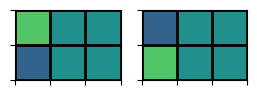

In [9]:
# Are the two directions of partially congruent cross decodable? 
# partial congruent stimulus (like grayscale color associated shape)
p = np.array([[1.0, 0.0, 0.0],
              [0.0, 0.0, 0.0]])
prt1_pat, prt1_mag = run_simple_predictive(p)

p = np.array([[0.0, 0.0, 0.0],
              [1.0, 0.0, 0.0]])
prt2_pat, prt2_mag = run_simple_predictive(p)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches((2*w, h))

plot_loc = [prt1_pat, prt2_pat]
for i, ax in enumerate(axs):
    ax.imshow(plot_loc[i].reshape((2, 3)), vmin=-1, vmax=1)
    ax.grid(True,  color='black', linewidth=2.0, which="major")
    ax.set_xticks(np.arange(-.5, 3, 1), minor=False)
    ax.set_yticks(np.arange(-.5, 2, 1), minor=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig.savefig(os.path.join(out_path, "percept_pattern_partial.svg"))
plt.show()

The concept layer is trivially cross decodable. There are other related top down frameworks that would show similar results, such as feature gain. However, there is no purely feedforward framework, regardless of normalization, that would explain both the differences in activation and the lack of cross decoding in low level areas. 